In [1]:
!pip install enchant

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for enchant from https://files.pythonhosted.org/packages/bb/ea/b7449b0d69361836ed68d0863374c27e395243fd1dbdd5587e62c479535c/enchant-0.0.1-py3-none-any.whl.metadata


In [2]:
# Ebook handling
import ebooklib
from ebooklib import epub
import fitz  # PyMuPDF

# Text preprocessing and NLP
import nltk
from nltk.corpus import stopwords, words, names
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('words')  # Consider moving nltk.download() calls to a setup script

# Machine learning and vector space modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

# Gensim for document vectorization
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from gensim.utils import simple_preprocess

# Data manipulation and mathematical operations
import numpy as np
from scipy.sparse import random

# Image processing and deep learning
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, Softmax
from tensorflow.keras.applications import mobilenet as _mobilenet

# Utilities
import os
import random
import re
from bs4 import BeautifulSoup

# Visualization and graph analysis
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import networkx as nx
from IPython.display import Image as iImage
from IPython.display import display

# Ensure to check for necessary library versions if you encounter issues,
# especially with tensorflow, nltk, sklearn, and gensim.


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\SherryAi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p
def find_BMU(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argmax(cos_sims, axis=None), cos_sims.shape)
def find_BMU_2(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argpartition(distSq, 2, axis=None)[2], distSq.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)
    return SOM

import scipy
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'sqeuclidean')[0][0]
    QE = sumSqDist/len(data)
    return QE

def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)

import sklearn
#这段代码实现了计算自组织映射（SOM）训练后的网络的U-矩阵（U-matrix）。U-矩阵是一种可视化工具，用于显示SOM中各单元之间的相似度
def euclidean(a, b):
    return np.linalg.norm(a-b)

def cosine(a,b):
    return cosine_similarity([a], [b])[0][0]

def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += cosine(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += cosine(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[cosine_similarity([normalP], [c])[0][0] for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    #activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

def remove_punctuation(text):
    # 使用正则表达式删除除了英文字母、逗号和句号之外的所有标点符号
    cleaned_text = re.sub(r'[^a-zA-Z,\.\s]', '', text)
    return cleaned_text

def is_english_word(word):
    return word.lower() in words.words()

def clean_text(text):
    words_list = text.split()
    valid_words = [word for word in words_list if is_english_word(word)]
    cleaned_text = ' '.join(valid_words)
    return cleaned_text

import fitz  # PyMuPDF

def preprocess(pdf_file, book_id, start_paragraph_nr):
    paragraphs = []
    paragraph_nr = start_paragraph_nr

    try:
        pdf = fitz.open(pdf_file)
    except Exception as e:
        print(f"Error reading {pdf_file}: {e}")
        return paragraphs, start_paragraph_nr

    for page_num in range(len(pdf)):  
        try:
            page = pdf[page_num]
            text = page.get_text()
            if text:
                text = re.sub('\s+', ' ', text)
                text = text.strip()
                content_paragraphs = text.split('.')
                merged_paragraph = ""

                for paragraph in content_paragraphs:
                    paragraph = paragraph.strip()
                    if len(paragraph) > 10:
                        if len(merged_paragraph) + len(paragraph) <= max_length:
                            merged_paragraph += paragraph + ". "
                        else:
                            if merged_paragraph:
                                paragraph_dict = {'paragraph': merged_paragraph.strip(), 'bookID': book_id, 'nr': paragraph_nr}
                                paragraphs.append(paragraph_dict)
                                paragraph_nr += 1
                            merged_paragraph = paragraph + ". "

                if merged_paragraph:
                    paragraph_dict = {'paragraph': merged_paragraph.strip(), 'bookID': book_id, 'nr': paragraph_nr}
                    paragraphs.append(paragraph_dict)
                    paragraph_nr += 1
        except Exception as e:
            print(f"Error processing page {page_num + 1} of {pdf_file}: {e}")

    return paragraphs, paragraph_nr

def process_all_pdf_files(folder_path):
    processed_data_list = []
    start_paragraph_nr = 0  # 设置起始段落编号

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith('.pdf'):
                pdf_file = os.path.join(root, filename)
                book_id = os.path.splitext(filename)[0]
                paragraphs, start_paragraph_nr = preprocess(pdf_file, book_id, start_paragraph_nr)
                processed_data_list.extend(paragraphs)
                print(f"Processed: {pdf_file}")

    return processed_data_list

In [4]:
folder_path = r"E:\term2\theater_script"

max_length = 400
processed_data_list = process_all_pdf_files(folder_path)
print(f"Total paragraphs processed: {len(processed_data_list)}")

Processed: E:\term2\theater_script\Beauty-is-a-Beast.pdf
Processed: E:\term2\theater_script\Calderon-de-La-Barca-Life-is-a-Dream.pdf
Processed: E:\term2\theater_script\Carmen.pdf
Processed: E:\term2\theater_script\Cats-Final-Draft.pdf
Processed: E:\term2\theater_script\celestinaeng.pdf
Processed: E:\term2\theater_script\Chicago-Script.pdf
Processed: E:\term2\theater_script\Cyrano-de-Bergerac.pdf
Processed: E:\term2\theater_script\El Burlador de Sevilla.pdf
Processed: E:\term2\theater_script\EVITA-Transcript-pdf-pdf.pdf
Processed: E:\term2\theater_script\Fuenteovejuna.pdf
Processed: E:\term2\theater_script\GREASE-script-English-2019-pdf.pdf
Processed: E:\term2\theater_script\HAIRSPRAY-Full-Script.pdf
Processed: E:\term2\theater_script\HAMLET.pdf
Processed: E:\term2\theater_script\INTO-THE-WOODS-SCRIPT-ACT-2-docx.pdf
Processed: E:\term2\theater_script\Les-Miserables-Script.pdf
Processed: E:\term2\theater_script\libretto-of-the-phantom-of-the-opera.pdf
Processed: E:\term2\theater_script\L

In [5]:
processed_data_list[0]

{'paragraph': "Beauty is a Beast Script Cast of Characters PRINCESS BEAUTY: (f) A spoiled princess who learns a lesson HONOR: (f) Beauty's kind sister NICK: (m) A young strong peasant who meets Beauty FAIRY: (f) Beauty's fairy godmother ANDRES: (m) A blind prince from a neighboring kingdom *JANIE: (f) Nick's sister SCRIBE: (m/f) A royal servant KING (or QUEEN): (m/f) Beauty and Honor's father (or mother) *TUTOR: (m/f) Beauty's tutor who has trouble tutoring her *GUARD: (m/f) A guard who makes Beauty's life difficult *NICK's brothers and sisters: PETER, PATTY, CINDY, JIMMY, SAM, and MANDY *PEASANTS with speaking roles: JILL, MEG, MAY, MARY, SARAH, TIM, JO, MOLLY, JOHN, SALLY, LADY There are also numerous non-speaking parts: GUARDS, PEASANTS, PARTYGOERS, SERVANTS, CHILDREN.",
 'bookID': 'Beauty-is-a-Beast',
 'nr': 0}

In [6]:
paragraph_list = [item['paragraph'] for item in processed_data_list if 'paragraph' in item]
lowercase_paragraphs = [text.lower() for text in paragraph_list]
cleaned_paragraphs = [remove_punctuation(paragraph) for paragraph in lowercase_paragraphs]
paragraph_list = cleaned_paragraphs
paragraph_list

['beauty is a beast script cast of characters princess beauty f a spoiled princess who learns a lesson honor f beautys kind sister nick m a young strong peasant who meets beauty fairy f beautys fairy godmother andres m a blind prince from a neighboring kingdom janie f nicks sister scribe mf a royal servant king or queen mf beauty and honors father or mother tutor mf beautys tutor who has trouble tutoring her guard mf a guard who makes beautys life difficult nicks brothers and sisters peter, patty, cindy, jimmy, sam, and mandy peasants with speaking roles jill, meg, may, mary, sarah, tim, jo, molly, john, sally, lady there are also numerous nonspeaking parts guards, peasants, partygoers, servants, children.',
 'parts that can be doubled. the following are some suggested ways of doubling parts guardpeter janietutor jojoejilllady sarahsallycindy marymegpatty petertimmayormayjohn samjimmybill this play can be performed with as few as  actors or with as many as desired.',
 'the kingdom of c

In [7]:
cleaned_paragraphs = []
for i, paragraph in enumerate(paragraph_list):
    cleaned_paragraph = clean_text(paragraph)
    cleaned_paragraphs.append(cleaned_paragraph)
    print(f"Processed paragraph {i + 1}/{len(paragraph_list)}")

Processed paragraph 1/14689
Processed paragraph 2/14689
Processed paragraph 3/14689
Processed paragraph 4/14689
Processed paragraph 5/14689
Processed paragraph 6/14689
Processed paragraph 7/14689
Processed paragraph 8/14689
Processed paragraph 9/14689
Processed paragraph 10/14689
Processed paragraph 11/14689
Processed paragraph 12/14689
Processed paragraph 13/14689
Processed paragraph 14/14689
Processed paragraph 15/14689
Processed paragraph 16/14689
Processed paragraph 17/14689
Processed paragraph 18/14689
Processed paragraph 19/14689
Processed paragraph 20/14689
Processed paragraph 21/14689
Processed paragraph 22/14689
Processed paragraph 23/14689
Processed paragraph 24/14689
Processed paragraph 25/14689
Processed paragraph 26/14689
Processed paragraph 27/14689
Processed paragraph 28/14689
Processed paragraph 29/14689
Processed paragraph 30/14689
Processed paragraph 31/14689
Processed paragraph 32/14689
Processed paragraph 33/14689
Processed paragraph 34/14689
Processed paragraph 35/

Processed paragraph 278/14689
Processed paragraph 279/14689
Processed paragraph 280/14689
Processed paragraph 281/14689
Processed paragraph 282/14689
Processed paragraph 283/14689
Processed paragraph 284/14689
Processed paragraph 285/14689
Processed paragraph 286/14689
Processed paragraph 287/14689
Processed paragraph 288/14689
Processed paragraph 289/14689
Processed paragraph 290/14689
Processed paragraph 291/14689
Processed paragraph 292/14689
Processed paragraph 293/14689
Processed paragraph 294/14689
Processed paragraph 295/14689
Processed paragraph 296/14689
Processed paragraph 297/14689
Processed paragraph 298/14689
Processed paragraph 299/14689
Processed paragraph 300/14689
Processed paragraph 301/14689
Processed paragraph 302/14689
Processed paragraph 303/14689
Processed paragraph 304/14689
Processed paragraph 305/14689
Processed paragraph 306/14689
Processed paragraph 307/14689
Processed paragraph 308/14689
Processed paragraph 309/14689
Processed paragraph 310/14689
Processed 

Processed paragraph 552/14689
Processed paragraph 553/14689
Processed paragraph 554/14689
Processed paragraph 555/14689
Processed paragraph 556/14689
Processed paragraph 557/14689
Processed paragraph 558/14689
Processed paragraph 559/14689
Processed paragraph 560/14689
Processed paragraph 561/14689
Processed paragraph 562/14689
Processed paragraph 563/14689
Processed paragraph 564/14689
Processed paragraph 565/14689
Processed paragraph 566/14689
Processed paragraph 567/14689
Processed paragraph 568/14689
Processed paragraph 569/14689
Processed paragraph 570/14689
Processed paragraph 571/14689
Processed paragraph 572/14689
Processed paragraph 573/14689
Processed paragraph 574/14689
Processed paragraph 575/14689
Processed paragraph 576/14689
Processed paragraph 577/14689
Processed paragraph 578/14689
Processed paragraph 579/14689
Processed paragraph 580/14689
Processed paragraph 581/14689
Processed paragraph 582/14689
Processed paragraph 583/14689
Processed paragraph 584/14689
Processed 

Processed paragraph 826/14689
Processed paragraph 827/14689
Processed paragraph 828/14689
Processed paragraph 829/14689
Processed paragraph 830/14689
Processed paragraph 831/14689
Processed paragraph 832/14689
Processed paragraph 833/14689
Processed paragraph 834/14689
Processed paragraph 835/14689
Processed paragraph 836/14689
Processed paragraph 837/14689
Processed paragraph 838/14689
Processed paragraph 839/14689
Processed paragraph 840/14689
Processed paragraph 841/14689
Processed paragraph 842/14689
Processed paragraph 843/14689
Processed paragraph 844/14689
Processed paragraph 845/14689
Processed paragraph 846/14689
Processed paragraph 847/14689
Processed paragraph 848/14689
Processed paragraph 849/14689
Processed paragraph 850/14689
Processed paragraph 851/14689
Processed paragraph 852/14689
Processed paragraph 853/14689
Processed paragraph 854/14689
Processed paragraph 855/14689
Processed paragraph 856/14689
Processed paragraph 857/14689
Processed paragraph 858/14689
Processed 

Processed paragraph 1096/14689
Processed paragraph 1097/14689
Processed paragraph 1098/14689
Processed paragraph 1099/14689
Processed paragraph 1100/14689
Processed paragraph 1101/14689
Processed paragraph 1102/14689
Processed paragraph 1103/14689
Processed paragraph 1104/14689
Processed paragraph 1105/14689
Processed paragraph 1106/14689
Processed paragraph 1107/14689
Processed paragraph 1108/14689
Processed paragraph 1109/14689
Processed paragraph 1110/14689
Processed paragraph 1111/14689
Processed paragraph 1112/14689
Processed paragraph 1113/14689
Processed paragraph 1114/14689
Processed paragraph 1115/14689
Processed paragraph 1116/14689
Processed paragraph 1117/14689
Processed paragraph 1118/14689
Processed paragraph 1119/14689
Processed paragraph 1120/14689
Processed paragraph 1121/14689
Processed paragraph 1122/14689
Processed paragraph 1123/14689
Processed paragraph 1124/14689
Processed paragraph 1125/14689
Processed paragraph 1126/14689
Processed paragraph 1127/14689
Processe

Processed paragraph 1361/14689
Processed paragraph 1362/14689
Processed paragraph 1363/14689
Processed paragraph 1364/14689
Processed paragraph 1365/14689
Processed paragraph 1366/14689
Processed paragraph 1367/14689
Processed paragraph 1368/14689
Processed paragraph 1369/14689
Processed paragraph 1370/14689
Processed paragraph 1371/14689
Processed paragraph 1372/14689
Processed paragraph 1373/14689
Processed paragraph 1374/14689
Processed paragraph 1375/14689
Processed paragraph 1376/14689
Processed paragraph 1377/14689
Processed paragraph 1378/14689
Processed paragraph 1379/14689
Processed paragraph 1380/14689
Processed paragraph 1381/14689
Processed paragraph 1382/14689
Processed paragraph 1383/14689
Processed paragraph 1384/14689
Processed paragraph 1385/14689
Processed paragraph 1386/14689
Processed paragraph 1387/14689
Processed paragraph 1388/14689
Processed paragraph 1389/14689
Processed paragraph 1390/14689
Processed paragraph 1391/14689
Processed paragraph 1392/14689
Processe

Processed paragraph 1626/14689
Processed paragraph 1627/14689
Processed paragraph 1628/14689
Processed paragraph 1629/14689
Processed paragraph 1630/14689
Processed paragraph 1631/14689
Processed paragraph 1632/14689
Processed paragraph 1633/14689
Processed paragraph 1634/14689
Processed paragraph 1635/14689
Processed paragraph 1636/14689
Processed paragraph 1637/14689
Processed paragraph 1638/14689
Processed paragraph 1639/14689
Processed paragraph 1640/14689
Processed paragraph 1641/14689
Processed paragraph 1642/14689
Processed paragraph 1643/14689
Processed paragraph 1644/14689
Processed paragraph 1645/14689
Processed paragraph 1646/14689
Processed paragraph 1647/14689
Processed paragraph 1648/14689
Processed paragraph 1649/14689
Processed paragraph 1650/14689
Processed paragraph 1651/14689
Processed paragraph 1652/14689
Processed paragraph 1653/14689
Processed paragraph 1654/14689
Processed paragraph 1655/14689
Processed paragraph 1656/14689
Processed paragraph 1657/14689
Processe

Processed paragraph 1891/14689
Processed paragraph 1892/14689
Processed paragraph 1893/14689
Processed paragraph 1894/14689
Processed paragraph 1895/14689
Processed paragraph 1896/14689
Processed paragraph 1897/14689
Processed paragraph 1898/14689
Processed paragraph 1899/14689
Processed paragraph 1900/14689
Processed paragraph 1901/14689
Processed paragraph 1902/14689
Processed paragraph 1903/14689
Processed paragraph 1904/14689
Processed paragraph 1905/14689
Processed paragraph 1906/14689
Processed paragraph 1907/14689
Processed paragraph 1908/14689
Processed paragraph 1909/14689
Processed paragraph 1910/14689
Processed paragraph 1911/14689
Processed paragraph 1912/14689
Processed paragraph 1913/14689
Processed paragraph 1914/14689
Processed paragraph 1915/14689
Processed paragraph 1916/14689
Processed paragraph 1917/14689
Processed paragraph 1918/14689
Processed paragraph 1919/14689
Processed paragraph 1920/14689
Processed paragraph 1921/14689
Processed paragraph 1922/14689
Processe

Processed paragraph 2156/14689
Processed paragraph 2157/14689
Processed paragraph 2158/14689
Processed paragraph 2159/14689
Processed paragraph 2160/14689
Processed paragraph 2161/14689
Processed paragraph 2162/14689
Processed paragraph 2163/14689
Processed paragraph 2164/14689
Processed paragraph 2165/14689
Processed paragraph 2166/14689
Processed paragraph 2167/14689
Processed paragraph 2168/14689
Processed paragraph 2169/14689
Processed paragraph 2170/14689
Processed paragraph 2171/14689
Processed paragraph 2172/14689
Processed paragraph 2173/14689
Processed paragraph 2174/14689
Processed paragraph 2175/14689
Processed paragraph 2176/14689
Processed paragraph 2177/14689
Processed paragraph 2178/14689
Processed paragraph 2179/14689
Processed paragraph 2180/14689
Processed paragraph 2181/14689
Processed paragraph 2182/14689
Processed paragraph 2183/14689
Processed paragraph 2184/14689
Processed paragraph 2185/14689
Processed paragraph 2186/14689
Processed paragraph 2187/14689
Processe

Processed paragraph 2421/14689
Processed paragraph 2422/14689
Processed paragraph 2423/14689
Processed paragraph 2424/14689
Processed paragraph 2425/14689
Processed paragraph 2426/14689
Processed paragraph 2427/14689
Processed paragraph 2428/14689
Processed paragraph 2429/14689
Processed paragraph 2430/14689
Processed paragraph 2431/14689
Processed paragraph 2432/14689
Processed paragraph 2433/14689
Processed paragraph 2434/14689
Processed paragraph 2435/14689
Processed paragraph 2436/14689
Processed paragraph 2437/14689
Processed paragraph 2438/14689
Processed paragraph 2439/14689
Processed paragraph 2440/14689
Processed paragraph 2441/14689
Processed paragraph 2442/14689
Processed paragraph 2443/14689
Processed paragraph 2444/14689
Processed paragraph 2445/14689
Processed paragraph 2446/14689
Processed paragraph 2447/14689
Processed paragraph 2448/14689
Processed paragraph 2449/14689
Processed paragraph 2450/14689
Processed paragraph 2451/14689
Processed paragraph 2452/14689
Processe

Processed paragraph 2686/14689
Processed paragraph 2687/14689
Processed paragraph 2688/14689
Processed paragraph 2689/14689
Processed paragraph 2690/14689
Processed paragraph 2691/14689
Processed paragraph 2692/14689
Processed paragraph 2693/14689
Processed paragraph 2694/14689
Processed paragraph 2695/14689
Processed paragraph 2696/14689
Processed paragraph 2697/14689
Processed paragraph 2698/14689
Processed paragraph 2699/14689
Processed paragraph 2700/14689
Processed paragraph 2701/14689
Processed paragraph 2702/14689
Processed paragraph 2703/14689
Processed paragraph 2704/14689
Processed paragraph 2705/14689
Processed paragraph 2706/14689
Processed paragraph 2707/14689
Processed paragraph 2708/14689
Processed paragraph 2709/14689
Processed paragraph 2710/14689
Processed paragraph 2711/14689
Processed paragraph 2712/14689
Processed paragraph 2713/14689
Processed paragraph 2714/14689
Processed paragraph 2715/14689
Processed paragraph 2716/14689
Processed paragraph 2717/14689
Processe

Processed paragraph 2951/14689
Processed paragraph 2952/14689
Processed paragraph 2953/14689
Processed paragraph 2954/14689
Processed paragraph 2955/14689
Processed paragraph 2956/14689
Processed paragraph 2957/14689
Processed paragraph 2958/14689
Processed paragraph 2959/14689
Processed paragraph 2960/14689
Processed paragraph 2961/14689
Processed paragraph 2962/14689
Processed paragraph 2963/14689
Processed paragraph 2964/14689
Processed paragraph 2965/14689
Processed paragraph 2966/14689
Processed paragraph 2967/14689
Processed paragraph 2968/14689
Processed paragraph 2969/14689
Processed paragraph 2970/14689
Processed paragraph 2971/14689
Processed paragraph 2972/14689
Processed paragraph 2973/14689
Processed paragraph 2974/14689
Processed paragraph 2975/14689
Processed paragraph 2976/14689
Processed paragraph 2977/14689
Processed paragraph 2978/14689
Processed paragraph 2979/14689
Processed paragraph 2980/14689
Processed paragraph 2981/14689
Processed paragraph 2982/14689
Processe

Processed paragraph 3216/14689
Processed paragraph 3217/14689
Processed paragraph 3218/14689
Processed paragraph 3219/14689
Processed paragraph 3220/14689
Processed paragraph 3221/14689
Processed paragraph 3222/14689
Processed paragraph 3223/14689
Processed paragraph 3224/14689
Processed paragraph 3225/14689
Processed paragraph 3226/14689
Processed paragraph 3227/14689
Processed paragraph 3228/14689
Processed paragraph 3229/14689
Processed paragraph 3230/14689
Processed paragraph 3231/14689
Processed paragraph 3232/14689
Processed paragraph 3233/14689
Processed paragraph 3234/14689
Processed paragraph 3235/14689
Processed paragraph 3236/14689
Processed paragraph 3237/14689
Processed paragraph 3238/14689
Processed paragraph 3239/14689
Processed paragraph 3240/14689
Processed paragraph 3241/14689
Processed paragraph 3242/14689
Processed paragraph 3243/14689
Processed paragraph 3244/14689
Processed paragraph 3245/14689
Processed paragraph 3246/14689
Processed paragraph 3247/14689
Processe

Processed paragraph 3481/14689
Processed paragraph 3482/14689
Processed paragraph 3483/14689
Processed paragraph 3484/14689
Processed paragraph 3485/14689
Processed paragraph 3486/14689
Processed paragraph 3487/14689
Processed paragraph 3488/14689
Processed paragraph 3489/14689
Processed paragraph 3490/14689
Processed paragraph 3491/14689
Processed paragraph 3492/14689
Processed paragraph 3493/14689
Processed paragraph 3494/14689
Processed paragraph 3495/14689
Processed paragraph 3496/14689
Processed paragraph 3497/14689
Processed paragraph 3498/14689
Processed paragraph 3499/14689
Processed paragraph 3500/14689
Processed paragraph 3501/14689
Processed paragraph 3502/14689
Processed paragraph 3503/14689
Processed paragraph 3504/14689
Processed paragraph 3505/14689
Processed paragraph 3506/14689
Processed paragraph 3507/14689
Processed paragraph 3508/14689
Processed paragraph 3509/14689
Processed paragraph 3510/14689
Processed paragraph 3511/14689
Processed paragraph 3512/14689
Processe

Processed paragraph 3746/14689
Processed paragraph 3747/14689
Processed paragraph 3748/14689
Processed paragraph 3749/14689
Processed paragraph 3750/14689
Processed paragraph 3751/14689
Processed paragraph 3752/14689
Processed paragraph 3753/14689
Processed paragraph 3754/14689
Processed paragraph 3755/14689
Processed paragraph 3756/14689
Processed paragraph 3757/14689
Processed paragraph 3758/14689
Processed paragraph 3759/14689
Processed paragraph 3760/14689
Processed paragraph 3761/14689
Processed paragraph 3762/14689
Processed paragraph 3763/14689
Processed paragraph 3764/14689
Processed paragraph 3765/14689
Processed paragraph 3766/14689
Processed paragraph 3767/14689
Processed paragraph 3768/14689
Processed paragraph 3769/14689
Processed paragraph 3770/14689
Processed paragraph 3771/14689
Processed paragraph 3772/14689
Processed paragraph 3773/14689
Processed paragraph 3774/14689
Processed paragraph 3775/14689
Processed paragraph 3776/14689
Processed paragraph 3777/14689
Processe

Processed paragraph 4011/14689
Processed paragraph 4012/14689
Processed paragraph 4013/14689
Processed paragraph 4014/14689
Processed paragraph 4015/14689
Processed paragraph 4016/14689
Processed paragraph 4017/14689
Processed paragraph 4018/14689
Processed paragraph 4019/14689
Processed paragraph 4020/14689
Processed paragraph 4021/14689
Processed paragraph 4022/14689
Processed paragraph 4023/14689
Processed paragraph 4024/14689
Processed paragraph 4025/14689
Processed paragraph 4026/14689
Processed paragraph 4027/14689
Processed paragraph 4028/14689
Processed paragraph 4029/14689
Processed paragraph 4030/14689
Processed paragraph 4031/14689
Processed paragraph 4032/14689
Processed paragraph 4033/14689
Processed paragraph 4034/14689
Processed paragraph 4035/14689
Processed paragraph 4036/14689
Processed paragraph 4037/14689
Processed paragraph 4038/14689
Processed paragraph 4039/14689
Processed paragraph 4040/14689
Processed paragraph 4041/14689
Processed paragraph 4042/14689
Processe

Processed paragraph 4276/14689
Processed paragraph 4277/14689
Processed paragraph 4278/14689
Processed paragraph 4279/14689
Processed paragraph 4280/14689
Processed paragraph 4281/14689
Processed paragraph 4282/14689
Processed paragraph 4283/14689
Processed paragraph 4284/14689
Processed paragraph 4285/14689
Processed paragraph 4286/14689
Processed paragraph 4287/14689
Processed paragraph 4288/14689
Processed paragraph 4289/14689
Processed paragraph 4290/14689
Processed paragraph 4291/14689
Processed paragraph 4292/14689
Processed paragraph 4293/14689
Processed paragraph 4294/14689
Processed paragraph 4295/14689
Processed paragraph 4296/14689
Processed paragraph 4297/14689
Processed paragraph 4298/14689
Processed paragraph 4299/14689
Processed paragraph 4300/14689
Processed paragraph 4301/14689
Processed paragraph 4302/14689
Processed paragraph 4303/14689
Processed paragraph 4304/14689
Processed paragraph 4305/14689
Processed paragraph 4306/14689
Processed paragraph 4307/14689
Processe

Processed paragraph 4541/14689
Processed paragraph 4542/14689
Processed paragraph 4543/14689
Processed paragraph 4544/14689
Processed paragraph 4545/14689
Processed paragraph 4546/14689
Processed paragraph 4547/14689
Processed paragraph 4548/14689
Processed paragraph 4549/14689
Processed paragraph 4550/14689
Processed paragraph 4551/14689
Processed paragraph 4552/14689
Processed paragraph 4553/14689
Processed paragraph 4554/14689
Processed paragraph 4555/14689
Processed paragraph 4556/14689
Processed paragraph 4557/14689
Processed paragraph 4558/14689
Processed paragraph 4559/14689
Processed paragraph 4560/14689
Processed paragraph 4561/14689
Processed paragraph 4562/14689
Processed paragraph 4563/14689
Processed paragraph 4564/14689
Processed paragraph 4565/14689
Processed paragraph 4566/14689
Processed paragraph 4567/14689
Processed paragraph 4568/14689
Processed paragraph 4569/14689
Processed paragraph 4570/14689
Processed paragraph 4571/14689
Processed paragraph 4572/14689
Processe

Processed paragraph 4806/14689
Processed paragraph 4807/14689
Processed paragraph 4808/14689
Processed paragraph 4809/14689
Processed paragraph 4810/14689
Processed paragraph 4811/14689
Processed paragraph 4812/14689
Processed paragraph 4813/14689
Processed paragraph 4814/14689
Processed paragraph 4815/14689
Processed paragraph 4816/14689
Processed paragraph 4817/14689
Processed paragraph 4818/14689
Processed paragraph 4819/14689
Processed paragraph 4820/14689
Processed paragraph 4821/14689
Processed paragraph 4822/14689
Processed paragraph 4823/14689
Processed paragraph 4824/14689
Processed paragraph 4825/14689
Processed paragraph 4826/14689
Processed paragraph 4827/14689
Processed paragraph 4828/14689
Processed paragraph 4829/14689
Processed paragraph 4830/14689
Processed paragraph 4831/14689
Processed paragraph 4832/14689
Processed paragraph 4833/14689
Processed paragraph 4834/14689
Processed paragraph 4835/14689
Processed paragraph 4836/14689
Processed paragraph 4837/14689
Processe

Processed paragraph 5071/14689
Processed paragraph 5072/14689
Processed paragraph 5073/14689
Processed paragraph 5074/14689
Processed paragraph 5075/14689
Processed paragraph 5076/14689
Processed paragraph 5077/14689
Processed paragraph 5078/14689
Processed paragraph 5079/14689
Processed paragraph 5080/14689
Processed paragraph 5081/14689
Processed paragraph 5082/14689
Processed paragraph 5083/14689
Processed paragraph 5084/14689
Processed paragraph 5085/14689
Processed paragraph 5086/14689
Processed paragraph 5087/14689
Processed paragraph 5088/14689
Processed paragraph 5089/14689
Processed paragraph 5090/14689
Processed paragraph 5091/14689
Processed paragraph 5092/14689
Processed paragraph 5093/14689
Processed paragraph 5094/14689
Processed paragraph 5095/14689
Processed paragraph 5096/14689
Processed paragraph 5097/14689
Processed paragraph 5098/14689
Processed paragraph 5099/14689
Processed paragraph 5100/14689
Processed paragraph 5101/14689
Processed paragraph 5102/14689
Processe

Processed paragraph 5336/14689
Processed paragraph 5337/14689
Processed paragraph 5338/14689
Processed paragraph 5339/14689
Processed paragraph 5340/14689
Processed paragraph 5341/14689
Processed paragraph 5342/14689
Processed paragraph 5343/14689
Processed paragraph 5344/14689
Processed paragraph 5345/14689
Processed paragraph 5346/14689
Processed paragraph 5347/14689
Processed paragraph 5348/14689
Processed paragraph 5349/14689
Processed paragraph 5350/14689
Processed paragraph 5351/14689
Processed paragraph 5352/14689
Processed paragraph 5353/14689
Processed paragraph 5354/14689
Processed paragraph 5355/14689
Processed paragraph 5356/14689
Processed paragraph 5357/14689
Processed paragraph 5358/14689
Processed paragraph 5359/14689
Processed paragraph 5360/14689
Processed paragraph 5361/14689
Processed paragraph 5362/14689
Processed paragraph 5363/14689
Processed paragraph 5364/14689
Processed paragraph 5365/14689
Processed paragraph 5366/14689
Processed paragraph 5367/14689
Processe

Processed paragraph 5601/14689
Processed paragraph 5602/14689
Processed paragraph 5603/14689
Processed paragraph 5604/14689
Processed paragraph 5605/14689
Processed paragraph 5606/14689
Processed paragraph 5607/14689
Processed paragraph 5608/14689
Processed paragraph 5609/14689
Processed paragraph 5610/14689
Processed paragraph 5611/14689
Processed paragraph 5612/14689
Processed paragraph 5613/14689
Processed paragraph 5614/14689
Processed paragraph 5615/14689
Processed paragraph 5616/14689
Processed paragraph 5617/14689
Processed paragraph 5618/14689
Processed paragraph 5619/14689
Processed paragraph 5620/14689
Processed paragraph 5621/14689
Processed paragraph 5622/14689
Processed paragraph 5623/14689
Processed paragraph 5624/14689
Processed paragraph 5625/14689
Processed paragraph 5626/14689
Processed paragraph 5627/14689
Processed paragraph 5628/14689
Processed paragraph 5629/14689
Processed paragraph 5630/14689
Processed paragraph 5631/14689
Processed paragraph 5632/14689
Processe

Processed paragraph 5866/14689
Processed paragraph 5867/14689
Processed paragraph 5868/14689
Processed paragraph 5869/14689
Processed paragraph 5870/14689
Processed paragraph 5871/14689
Processed paragraph 5872/14689
Processed paragraph 5873/14689
Processed paragraph 5874/14689
Processed paragraph 5875/14689
Processed paragraph 5876/14689
Processed paragraph 5877/14689
Processed paragraph 5878/14689
Processed paragraph 5879/14689
Processed paragraph 5880/14689
Processed paragraph 5881/14689
Processed paragraph 5882/14689
Processed paragraph 5883/14689
Processed paragraph 5884/14689
Processed paragraph 5885/14689
Processed paragraph 5886/14689
Processed paragraph 5887/14689
Processed paragraph 5888/14689
Processed paragraph 5889/14689
Processed paragraph 5890/14689
Processed paragraph 5891/14689
Processed paragraph 5892/14689
Processed paragraph 5893/14689
Processed paragraph 5894/14689
Processed paragraph 5895/14689
Processed paragraph 5896/14689
Processed paragraph 5897/14689
Processe

Processed paragraph 6131/14689
Processed paragraph 6132/14689
Processed paragraph 6133/14689
Processed paragraph 6134/14689
Processed paragraph 6135/14689
Processed paragraph 6136/14689
Processed paragraph 6137/14689
Processed paragraph 6138/14689
Processed paragraph 6139/14689
Processed paragraph 6140/14689
Processed paragraph 6141/14689
Processed paragraph 6142/14689
Processed paragraph 6143/14689
Processed paragraph 6144/14689
Processed paragraph 6145/14689
Processed paragraph 6146/14689
Processed paragraph 6147/14689
Processed paragraph 6148/14689
Processed paragraph 6149/14689
Processed paragraph 6150/14689
Processed paragraph 6151/14689
Processed paragraph 6152/14689
Processed paragraph 6153/14689
Processed paragraph 6154/14689
Processed paragraph 6155/14689
Processed paragraph 6156/14689
Processed paragraph 6157/14689
Processed paragraph 6158/14689
Processed paragraph 6159/14689
Processed paragraph 6160/14689
Processed paragraph 6161/14689
Processed paragraph 6162/14689
Processe

Processed paragraph 6396/14689
Processed paragraph 6397/14689
Processed paragraph 6398/14689
Processed paragraph 6399/14689
Processed paragraph 6400/14689
Processed paragraph 6401/14689
Processed paragraph 6402/14689
Processed paragraph 6403/14689
Processed paragraph 6404/14689
Processed paragraph 6405/14689
Processed paragraph 6406/14689
Processed paragraph 6407/14689
Processed paragraph 6408/14689
Processed paragraph 6409/14689
Processed paragraph 6410/14689
Processed paragraph 6411/14689
Processed paragraph 6412/14689
Processed paragraph 6413/14689
Processed paragraph 6414/14689
Processed paragraph 6415/14689
Processed paragraph 6416/14689
Processed paragraph 6417/14689
Processed paragraph 6418/14689
Processed paragraph 6419/14689
Processed paragraph 6420/14689
Processed paragraph 6421/14689
Processed paragraph 6422/14689
Processed paragraph 6423/14689
Processed paragraph 6424/14689
Processed paragraph 6425/14689
Processed paragraph 6426/14689
Processed paragraph 6427/14689
Processe

Processed paragraph 6661/14689
Processed paragraph 6662/14689
Processed paragraph 6663/14689
Processed paragraph 6664/14689
Processed paragraph 6665/14689
Processed paragraph 6666/14689
Processed paragraph 6667/14689
Processed paragraph 6668/14689
Processed paragraph 6669/14689
Processed paragraph 6670/14689
Processed paragraph 6671/14689
Processed paragraph 6672/14689
Processed paragraph 6673/14689
Processed paragraph 6674/14689
Processed paragraph 6675/14689
Processed paragraph 6676/14689
Processed paragraph 6677/14689
Processed paragraph 6678/14689
Processed paragraph 6679/14689
Processed paragraph 6680/14689
Processed paragraph 6681/14689
Processed paragraph 6682/14689
Processed paragraph 6683/14689
Processed paragraph 6684/14689
Processed paragraph 6685/14689
Processed paragraph 6686/14689
Processed paragraph 6687/14689
Processed paragraph 6688/14689
Processed paragraph 6689/14689
Processed paragraph 6690/14689
Processed paragraph 6691/14689
Processed paragraph 6692/14689
Processe

Processed paragraph 6926/14689
Processed paragraph 6927/14689
Processed paragraph 6928/14689
Processed paragraph 6929/14689
Processed paragraph 6930/14689
Processed paragraph 6931/14689
Processed paragraph 6932/14689
Processed paragraph 6933/14689
Processed paragraph 6934/14689
Processed paragraph 6935/14689
Processed paragraph 6936/14689
Processed paragraph 6937/14689
Processed paragraph 6938/14689
Processed paragraph 6939/14689
Processed paragraph 6940/14689
Processed paragraph 6941/14689
Processed paragraph 6942/14689
Processed paragraph 6943/14689
Processed paragraph 6944/14689
Processed paragraph 6945/14689
Processed paragraph 6946/14689
Processed paragraph 6947/14689
Processed paragraph 6948/14689
Processed paragraph 6949/14689
Processed paragraph 6950/14689
Processed paragraph 6951/14689
Processed paragraph 6952/14689
Processed paragraph 6953/14689
Processed paragraph 6954/14689
Processed paragraph 6955/14689
Processed paragraph 6956/14689
Processed paragraph 6957/14689
Processe

Processed paragraph 7191/14689
Processed paragraph 7192/14689
Processed paragraph 7193/14689
Processed paragraph 7194/14689
Processed paragraph 7195/14689
Processed paragraph 7196/14689
Processed paragraph 7197/14689
Processed paragraph 7198/14689
Processed paragraph 7199/14689
Processed paragraph 7200/14689
Processed paragraph 7201/14689
Processed paragraph 7202/14689
Processed paragraph 7203/14689
Processed paragraph 7204/14689
Processed paragraph 7205/14689
Processed paragraph 7206/14689
Processed paragraph 7207/14689
Processed paragraph 7208/14689
Processed paragraph 7209/14689
Processed paragraph 7210/14689
Processed paragraph 7211/14689
Processed paragraph 7212/14689
Processed paragraph 7213/14689
Processed paragraph 7214/14689
Processed paragraph 7215/14689
Processed paragraph 7216/14689
Processed paragraph 7217/14689
Processed paragraph 7218/14689
Processed paragraph 7219/14689
Processed paragraph 7220/14689
Processed paragraph 7221/14689
Processed paragraph 7222/14689
Processe

Processed paragraph 7457/14689
Processed paragraph 7458/14689
Processed paragraph 7459/14689
Processed paragraph 7460/14689
Processed paragraph 7461/14689
Processed paragraph 7462/14689
Processed paragraph 7463/14689
Processed paragraph 7464/14689
Processed paragraph 7465/14689
Processed paragraph 7466/14689
Processed paragraph 7467/14689
Processed paragraph 7468/14689
Processed paragraph 7469/14689
Processed paragraph 7470/14689
Processed paragraph 7471/14689
Processed paragraph 7472/14689
Processed paragraph 7473/14689
Processed paragraph 7474/14689
Processed paragraph 7475/14689
Processed paragraph 7476/14689
Processed paragraph 7477/14689
Processed paragraph 7478/14689
Processed paragraph 7479/14689
Processed paragraph 7480/14689
Processed paragraph 7481/14689
Processed paragraph 7482/14689
Processed paragraph 7483/14689
Processed paragraph 7484/14689
Processed paragraph 7485/14689
Processed paragraph 7486/14689
Processed paragraph 7487/14689
Processed paragraph 7488/14689
Processe

Processed paragraph 7722/14689
Processed paragraph 7723/14689
Processed paragraph 7724/14689
Processed paragraph 7725/14689
Processed paragraph 7726/14689
Processed paragraph 7727/14689
Processed paragraph 7728/14689
Processed paragraph 7729/14689
Processed paragraph 7730/14689
Processed paragraph 7731/14689
Processed paragraph 7732/14689
Processed paragraph 7733/14689
Processed paragraph 7734/14689
Processed paragraph 7735/14689
Processed paragraph 7736/14689
Processed paragraph 7737/14689
Processed paragraph 7738/14689
Processed paragraph 7739/14689
Processed paragraph 7740/14689
Processed paragraph 7741/14689
Processed paragraph 7742/14689
Processed paragraph 7743/14689
Processed paragraph 7744/14689
Processed paragraph 7745/14689
Processed paragraph 7746/14689
Processed paragraph 7747/14689
Processed paragraph 7748/14689
Processed paragraph 7749/14689
Processed paragraph 7750/14689
Processed paragraph 7751/14689
Processed paragraph 7752/14689
Processed paragraph 7753/14689
Processe

Processed paragraph 7987/14689
Processed paragraph 7988/14689
Processed paragraph 7989/14689
Processed paragraph 7990/14689
Processed paragraph 7991/14689
Processed paragraph 7992/14689
Processed paragraph 7993/14689
Processed paragraph 7994/14689
Processed paragraph 7995/14689
Processed paragraph 7996/14689
Processed paragraph 7997/14689
Processed paragraph 7998/14689
Processed paragraph 7999/14689
Processed paragraph 8000/14689
Processed paragraph 8001/14689
Processed paragraph 8002/14689
Processed paragraph 8003/14689
Processed paragraph 8004/14689
Processed paragraph 8005/14689
Processed paragraph 8006/14689
Processed paragraph 8007/14689
Processed paragraph 8008/14689
Processed paragraph 8009/14689
Processed paragraph 8010/14689
Processed paragraph 8011/14689
Processed paragraph 8012/14689
Processed paragraph 8013/14689
Processed paragraph 8014/14689
Processed paragraph 8015/14689
Processed paragraph 8016/14689
Processed paragraph 8017/14689
Processed paragraph 8018/14689
Processe

Processed paragraph 8252/14689
Processed paragraph 8253/14689
Processed paragraph 8254/14689
Processed paragraph 8255/14689
Processed paragraph 8256/14689
Processed paragraph 8257/14689
Processed paragraph 8258/14689
Processed paragraph 8259/14689
Processed paragraph 8260/14689
Processed paragraph 8261/14689
Processed paragraph 8262/14689
Processed paragraph 8263/14689
Processed paragraph 8264/14689
Processed paragraph 8265/14689
Processed paragraph 8266/14689
Processed paragraph 8267/14689
Processed paragraph 8268/14689
Processed paragraph 8269/14689
Processed paragraph 8270/14689
Processed paragraph 8271/14689
Processed paragraph 8272/14689
Processed paragraph 8273/14689
Processed paragraph 8274/14689
Processed paragraph 8275/14689
Processed paragraph 8276/14689
Processed paragraph 8277/14689
Processed paragraph 8278/14689
Processed paragraph 8279/14689
Processed paragraph 8280/14689
Processed paragraph 8281/14689
Processed paragraph 8282/14689
Processed paragraph 8283/14689
Processe

Processed paragraph 8517/14689
Processed paragraph 8518/14689
Processed paragraph 8519/14689
Processed paragraph 8520/14689
Processed paragraph 8521/14689
Processed paragraph 8522/14689
Processed paragraph 8523/14689
Processed paragraph 8524/14689
Processed paragraph 8525/14689
Processed paragraph 8526/14689
Processed paragraph 8527/14689
Processed paragraph 8528/14689
Processed paragraph 8529/14689
Processed paragraph 8530/14689
Processed paragraph 8531/14689
Processed paragraph 8532/14689
Processed paragraph 8533/14689
Processed paragraph 8534/14689
Processed paragraph 8535/14689
Processed paragraph 8536/14689
Processed paragraph 8537/14689
Processed paragraph 8538/14689
Processed paragraph 8539/14689
Processed paragraph 8540/14689
Processed paragraph 8541/14689
Processed paragraph 8542/14689
Processed paragraph 8543/14689
Processed paragraph 8544/14689
Processed paragraph 8545/14689
Processed paragraph 8546/14689
Processed paragraph 8547/14689
Processed paragraph 8548/14689
Processe

Processed paragraph 8782/14689
Processed paragraph 8783/14689
Processed paragraph 8784/14689
Processed paragraph 8785/14689
Processed paragraph 8786/14689
Processed paragraph 8787/14689
Processed paragraph 8788/14689
Processed paragraph 8789/14689
Processed paragraph 8790/14689
Processed paragraph 8791/14689
Processed paragraph 8792/14689
Processed paragraph 8793/14689
Processed paragraph 8794/14689
Processed paragraph 8795/14689
Processed paragraph 8796/14689
Processed paragraph 8797/14689
Processed paragraph 8798/14689
Processed paragraph 8799/14689
Processed paragraph 8800/14689
Processed paragraph 8801/14689
Processed paragraph 8802/14689
Processed paragraph 8803/14689
Processed paragraph 8804/14689
Processed paragraph 8805/14689
Processed paragraph 8806/14689
Processed paragraph 8807/14689
Processed paragraph 8808/14689
Processed paragraph 8809/14689
Processed paragraph 8810/14689
Processed paragraph 8811/14689
Processed paragraph 8812/14689
Processed paragraph 8813/14689
Processe

Processed paragraph 9047/14689
Processed paragraph 9048/14689
Processed paragraph 9049/14689
Processed paragraph 9050/14689
Processed paragraph 9051/14689
Processed paragraph 9052/14689
Processed paragraph 9053/14689
Processed paragraph 9054/14689
Processed paragraph 9055/14689
Processed paragraph 9056/14689
Processed paragraph 9057/14689
Processed paragraph 9058/14689
Processed paragraph 9059/14689
Processed paragraph 9060/14689
Processed paragraph 9061/14689
Processed paragraph 9062/14689
Processed paragraph 9063/14689
Processed paragraph 9064/14689
Processed paragraph 9065/14689
Processed paragraph 9066/14689
Processed paragraph 9067/14689
Processed paragraph 9068/14689
Processed paragraph 9069/14689
Processed paragraph 9070/14689
Processed paragraph 9071/14689
Processed paragraph 9072/14689
Processed paragraph 9073/14689
Processed paragraph 9074/14689
Processed paragraph 9075/14689
Processed paragraph 9076/14689
Processed paragraph 9077/14689
Processed paragraph 9078/14689
Processe

Processed paragraph 9312/14689
Processed paragraph 9313/14689
Processed paragraph 9314/14689
Processed paragraph 9315/14689
Processed paragraph 9316/14689
Processed paragraph 9317/14689
Processed paragraph 9318/14689
Processed paragraph 9319/14689
Processed paragraph 9320/14689
Processed paragraph 9321/14689
Processed paragraph 9322/14689
Processed paragraph 9323/14689
Processed paragraph 9324/14689
Processed paragraph 9325/14689
Processed paragraph 9326/14689
Processed paragraph 9327/14689
Processed paragraph 9328/14689
Processed paragraph 9329/14689
Processed paragraph 9330/14689
Processed paragraph 9331/14689
Processed paragraph 9332/14689
Processed paragraph 9333/14689
Processed paragraph 9334/14689
Processed paragraph 9335/14689
Processed paragraph 9336/14689
Processed paragraph 9337/14689
Processed paragraph 9338/14689
Processed paragraph 9339/14689
Processed paragraph 9340/14689
Processed paragraph 9341/14689
Processed paragraph 9342/14689
Processed paragraph 9343/14689
Processe

Processed paragraph 9577/14689
Processed paragraph 9578/14689
Processed paragraph 9579/14689
Processed paragraph 9580/14689
Processed paragraph 9581/14689
Processed paragraph 9582/14689
Processed paragraph 9583/14689
Processed paragraph 9584/14689
Processed paragraph 9585/14689
Processed paragraph 9586/14689
Processed paragraph 9587/14689
Processed paragraph 9588/14689
Processed paragraph 9589/14689
Processed paragraph 9590/14689
Processed paragraph 9591/14689
Processed paragraph 9592/14689
Processed paragraph 9593/14689
Processed paragraph 9594/14689
Processed paragraph 9595/14689
Processed paragraph 9596/14689
Processed paragraph 9597/14689
Processed paragraph 9598/14689
Processed paragraph 9599/14689
Processed paragraph 9600/14689
Processed paragraph 9601/14689
Processed paragraph 9602/14689
Processed paragraph 9603/14689
Processed paragraph 9604/14689
Processed paragraph 9605/14689
Processed paragraph 9606/14689
Processed paragraph 9607/14689
Processed paragraph 9608/14689
Processe

Processed paragraph 9842/14689
Processed paragraph 9843/14689
Processed paragraph 9844/14689
Processed paragraph 9845/14689
Processed paragraph 9846/14689
Processed paragraph 9847/14689
Processed paragraph 9848/14689
Processed paragraph 9849/14689
Processed paragraph 9850/14689
Processed paragraph 9851/14689
Processed paragraph 9852/14689
Processed paragraph 9853/14689
Processed paragraph 9854/14689
Processed paragraph 9855/14689
Processed paragraph 9856/14689
Processed paragraph 9857/14689
Processed paragraph 9858/14689
Processed paragraph 9859/14689
Processed paragraph 9860/14689
Processed paragraph 9861/14689
Processed paragraph 9862/14689
Processed paragraph 9863/14689
Processed paragraph 9864/14689
Processed paragraph 9865/14689
Processed paragraph 9866/14689
Processed paragraph 9867/14689
Processed paragraph 9868/14689
Processed paragraph 9869/14689
Processed paragraph 9870/14689
Processed paragraph 9871/14689
Processed paragraph 9872/14689
Processed paragraph 9873/14689
Processe

Processed paragraph 10103/14689
Processed paragraph 10104/14689
Processed paragraph 10105/14689
Processed paragraph 10106/14689
Processed paragraph 10107/14689
Processed paragraph 10108/14689
Processed paragraph 10109/14689
Processed paragraph 10110/14689
Processed paragraph 10111/14689
Processed paragraph 10112/14689
Processed paragraph 10113/14689
Processed paragraph 10114/14689
Processed paragraph 10115/14689
Processed paragraph 10116/14689
Processed paragraph 10117/14689
Processed paragraph 10118/14689
Processed paragraph 10119/14689
Processed paragraph 10120/14689
Processed paragraph 10121/14689
Processed paragraph 10122/14689
Processed paragraph 10123/14689
Processed paragraph 10124/14689
Processed paragraph 10125/14689
Processed paragraph 10126/14689
Processed paragraph 10127/14689
Processed paragraph 10128/14689
Processed paragraph 10129/14689
Processed paragraph 10130/14689
Processed paragraph 10131/14689
Processed paragraph 10132/14689
Processed paragraph 10133/14689
Processe

Processed paragraph 10360/14689
Processed paragraph 10361/14689
Processed paragraph 10362/14689
Processed paragraph 10363/14689
Processed paragraph 10364/14689
Processed paragraph 10365/14689
Processed paragraph 10366/14689
Processed paragraph 10367/14689
Processed paragraph 10368/14689
Processed paragraph 10369/14689
Processed paragraph 10370/14689
Processed paragraph 10371/14689
Processed paragraph 10372/14689
Processed paragraph 10373/14689
Processed paragraph 10374/14689
Processed paragraph 10375/14689
Processed paragraph 10376/14689
Processed paragraph 10377/14689
Processed paragraph 10378/14689
Processed paragraph 10379/14689
Processed paragraph 10380/14689
Processed paragraph 10381/14689
Processed paragraph 10382/14689
Processed paragraph 10383/14689
Processed paragraph 10384/14689
Processed paragraph 10385/14689
Processed paragraph 10386/14689
Processed paragraph 10387/14689
Processed paragraph 10388/14689
Processed paragraph 10389/14689
Processed paragraph 10390/14689
Processe

Processed paragraph 10617/14689
Processed paragraph 10618/14689
Processed paragraph 10619/14689
Processed paragraph 10620/14689
Processed paragraph 10621/14689
Processed paragraph 10622/14689
Processed paragraph 10623/14689
Processed paragraph 10624/14689
Processed paragraph 10625/14689
Processed paragraph 10626/14689
Processed paragraph 10627/14689
Processed paragraph 10628/14689
Processed paragraph 10629/14689
Processed paragraph 10630/14689
Processed paragraph 10631/14689
Processed paragraph 10632/14689
Processed paragraph 10633/14689
Processed paragraph 10634/14689
Processed paragraph 10635/14689
Processed paragraph 10636/14689
Processed paragraph 10637/14689
Processed paragraph 10638/14689
Processed paragraph 10639/14689
Processed paragraph 10640/14689
Processed paragraph 10641/14689
Processed paragraph 10642/14689
Processed paragraph 10643/14689
Processed paragraph 10644/14689
Processed paragraph 10645/14689
Processed paragraph 10646/14689
Processed paragraph 10647/14689
Processe

Processed paragraph 10874/14689
Processed paragraph 10875/14689
Processed paragraph 10876/14689
Processed paragraph 10877/14689
Processed paragraph 10878/14689
Processed paragraph 10879/14689
Processed paragraph 10880/14689
Processed paragraph 10881/14689
Processed paragraph 10882/14689
Processed paragraph 10883/14689
Processed paragraph 10884/14689
Processed paragraph 10885/14689
Processed paragraph 10886/14689
Processed paragraph 10887/14689
Processed paragraph 10888/14689
Processed paragraph 10889/14689
Processed paragraph 10890/14689
Processed paragraph 10891/14689
Processed paragraph 10892/14689
Processed paragraph 10893/14689
Processed paragraph 10894/14689
Processed paragraph 10895/14689
Processed paragraph 10896/14689
Processed paragraph 10897/14689
Processed paragraph 10898/14689
Processed paragraph 10899/14689
Processed paragraph 10900/14689
Processed paragraph 10901/14689
Processed paragraph 10902/14689
Processed paragraph 10903/14689
Processed paragraph 10904/14689
Processe

Processed paragraph 11131/14689
Processed paragraph 11132/14689
Processed paragraph 11133/14689
Processed paragraph 11134/14689
Processed paragraph 11135/14689
Processed paragraph 11136/14689
Processed paragraph 11137/14689
Processed paragraph 11138/14689
Processed paragraph 11139/14689
Processed paragraph 11140/14689
Processed paragraph 11141/14689
Processed paragraph 11142/14689
Processed paragraph 11143/14689
Processed paragraph 11144/14689
Processed paragraph 11145/14689
Processed paragraph 11146/14689
Processed paragraph 11147/14689
Processed paragraph 11148/14689
Processed paragraph 11149/14689
Processed paragraph 11150/14689
Processed paragraph 11151/14689
Processed paragraph 11152/14689
Processed paragraph 11153/14689
Processed paragraph 11154/14689
Processed paragraph 11155/14689
Processed paragraph 11156/14689
Processed paragraph 11157/14689
Processed paragraph 11158/14689
Processed paragraph 11159/14689
Processed paragraph 11160/14689
Processed paragraph 11161/14689
Processe

Processed paragraph 11388/14689
Processed paragraph 11389/14689
Processed paragraph 11390/14689
Processed paragraph 11391/14689
Processed paragraph 11392/14689
Processed paragraph 11393/14689
Processed paragraph 11394/14689
Processed paragraph 11395/14689
Processed paragraph 11396/14689
Processed paragraph 11397/14689
Processed paragraph 11398/14689
Processed paragraph 11399/14689
Processed paragraph 11400/14689
Processed paragraph 11401/14689
Processed paragraph 11402/14689
Processed paragraph 11403/14689
Processed paragraph 11404/14689
Processed paragraph 11405/14689
Processed paragraph 11406/14689
Processed paragraph 11407/14689
Processed paragraph 11408/14689
Processed paragraph 11409/14689
Processed paragraph 11410/14689
Processed paragraph 11411/14689
Processed paragraph 11412/14689
Processed paragraph 11413/14689
Processed paragraph 11414/14689
Processed paragraph 11415/14689
Processed paragraph 11416/14689
Processed paragraph 11417/14689
Processed paragraph 11418/14689
Processe

Processed paragraph 11645/14689
Processed paragraph 11646/14689
Processed paragraph 11647/14689
Processed paragraph 11648/14689
Processed paragraph 11649/14689
Processed paragraph 11650/14689
Processed paragraph 11651/14689
Processed paragraph 11652/14689
Processed paragraph 11653/14689
Processed paragraph 11654/14689
Processed paragraph 11655/14689
Processed paragraph 11656/14689
Processed paragraph 11657/14689
Processed paragraph 11658/14689
Processed paragraph 11659/14689
Processed paragraph 11660/14689
Processed paragraph 11661/14689
Processed paragraph 11662/14689
Processed paragraph 11663/14689
Processed paragraph 11664/14689
Processed paragraph 11665/14689
Processed paragraph 11666/14689
Processed paragraph 11667/14689
Processed paragraph 11668/14689
Processed paragraph 11669/14689
Processed paragraph 11670/14689
Processed paragraph 11671/14689
Processed paragraph 11672/14689
Processed paragraph 11673/14689
Processed paragraph 11674/14689
Processed paragraph 11675/14689
Processe

Processed paragraph 11902/14689
Processed paragraph 11903/14689
Processed paragraph 11904/14689
Processed paragraph 11905/14689
Processed paragraph 11906/14689
Processed paragraph 11907/14689
Processed paragraph 11908/14689
Processed paragraph 11909/14689
Processed paragraph 11910/14689
Processed paragraph 11911/14689
Processed paragraph 11912/14689
Processed paragraph 11913/14689
Processed paragraph 11914/14689
Processed paragraph 11915/14689
Processed paragraph 11916/14689
Processed paragraph 11917/14689
Processed paragraph 11918/14689
Processed paragraph 11919/14689
Processed paragraph 11920/14689
Processed paragraph 11921/14689
Processed paragraph 11922/14689
Processed paragraph 11923/14689
Processed paragraph 11924/14689
Processed paragraph 11925/14689
Processed paragraph 11926/14689
Processed paragraph 11927/14689
Processed paragraph 11928/14689
Processed paragraph 11929/14689
Processed paragraph 11930/14689
Processed paragraph 11931/14689
Processed paragraph 11932/14689
Processe

Processed paragraph 12159/14689
Processed paragraph 12160/14689
Processed paragraph 12161/14689
Processed paragraph 12162/14689
Processed paragraph 12163/14689
Processed paragraph 12164/14689
Processed paragraph 12165/14689
Processed paragraph 12166/14689
Processed paragraph 12167/14689
Processed paragraph 12168/14689
Processed paragraph 12169/14689
Processed paragraph 12170/14689
Processed paragraph 12171/14689
Processed paragraph 12172/14689
Processed paragraph 12173/14689
Processed paragraph 12174/14689
Processed paragraph 12175/14689
Processed paragraph 12176/14689
Processed paragraph 12177/14689
Processed paragraph 12178/14689
Processed paragraph 12179/14689
Processed paragraph 12180/14689
Processed paragraph 12181/14689
Processed paragraph 12182/14689
Processed paragraph 12183/14689
Processed paragraph 12184/14689
Processed paragraph 12185/14689
Processed paragraph 12186/14689
Processed paragraph 12187/14689
Processed paragraph 12188/14689
Processed paragraph 12189/14689
Processe

Processed paragraph 12416/14689
Processed paragraph 12417/14689
Processed paragraph 12418/14689
Processed paragraph 12419/14689
Processed paragraph 12420/14689
Processed paragraph 12421/14689
Processed paragraph 12422/14689
Processed paragraph 12423/14689
Processed paragraph 12424/14689
Processed paragraph 12425/14689
Processed paragraph 12426/14689
Processed paragraph 12427/14689
Processed paragraph 12428/14689
Processed paragraph 12429/14689
Processed paragraph 12430/14689
Processed paragraph 12431/14689
Processed paragraph 12432/14689
Processed paragraph 12433/14689
Processed paragraph 12434/14689
Processed paragraph 12435/14689
Processed paragraph 12436/14689
Processed paragraph 12437/14689
Processed paragraph 12438/14689
Processed paragraph 12439/14689
Processed paragraph 12440/14689
Processed paragraph 12441/14689
Processed paragraph 12442/14689
Processed paragraph 12443/14689
Processed paragraph 12444/14689
Processed paragraph 12445/14689
Processed paragraph 12446/14689
Processe

Processed paragraph 12673/14689
Processed paragraph 12674/14689
Processed paragraph 12675/14689
Processed paragraph 12676/14689
Processed paragraph 12677/14689
Processed paragraph 12678/14689
Processed paragraph 12679/14689
Processed paragraph 12680/14689
Processed paragraph 12681/14689
Processed paragraph 12682/14689
Processed paragraph 12683/14689
Processed paragraph 12684/14689
Processed paragraph 12685/14689
Processed paragraph 12686/14689
Processed paragraph 12687/14689
Processed paragraph 12688/14689
Processed paragraph 12689/14689
Processed paragraph 12690/14689
Processed paragraph 12691/14689
Processed paragraph 12692/14689
Processed paragraph 12693/14689
Processed paragraph 12694/14689
Processed paragraph 12695/14689
Processed paragraph 12696/14689
Processed paragraph 12697/14689
Processed paragraph 12698/14689
Processed paragraph 12699/14689
Processed paragraph 12700/14689
Processed paragraph 12701/14689
Processed paragraph 12702/14689
Processed paragraph 12703/14689
Processe

Processed paragraph 12930/14689
Processed paragraph 12931/14689
Processed paragraph 12932/14689
Processed paragraph 12933/14689
Processed paragraph 12934/14689
Processed paragraph 12935/14689
Processed paragraph 12936/14689
Processed paragraph 12937/14689
Processed paragraph 12938/14689
Processed paragraph 12939/14689
Processed paragraph 12940/14689
Processed paragraph 12941/14689
Processed paragraph 12942/14689
Processed paragraph 12943/14689
Processed paragraph 12944/14689
Processed paragraph 12945/14689
Processed paragraph 12946/14689
Processed paragraph 12947/14689
Processed paragraph 12948/14689
Processed paragraph 12949/14689
Processed paragraph 12950/14689
Processed paragraph 12951/14689
Processed paragraph 12952/14689
Processed paragraph 12953/14689
Processed paragraph 12954/14689
Processed paragraph 12955/14689
Processed paragraph 12956/14689
Processed paragraph 12957/14689
Processed paragraph 12958/14689
Processed paragraph 12959/14689
Processed paragraph 12960/14689
Processe

Processed paragraph 13187/14689
Processed paragraph 13188/14689
Processed paragraph 13189/14689
Processed paragraph 13190/14689
Processed paragraph 13191/14689
Processed paragraph 13192/14689
Processed paragraph 13193/14689
Processed paragraph 13194/14689
Processed paragraph 13195/14689
Processed paragraph 13196/14689
Processed paragraph 13197/14689
Processed paragraph 13198/14689
Processed paragraph 13199/14689
Processed paragraph 13200/14689
Processed paragraph 13201/14689
Processed paragraph 13202/14689
Processed paragraph 13203/14689
Processed paragraph 13204/14689
Processed paragraph 13205/14689
Processed paragraph 13206/14689
Processed paragraph 13207/14689
Processed paragraph 13208/14689
Processed paragraph 13209/14689
Processed paragraph 13210/14689
Processed paragraph 13211/14689
Processed paragraph 13212/14689
Processed paragraph 13213/14689
Processed paragraph 13214/14689
Processed paragraph 13215/14689
Processed paragraph 13216/14689
Processed paragraph 13217/14689
Processe

Processed paragraph 13444/14689
Processed paragraph 13445/14689
Processed paragraph 13446/14689
Processed paragraph 13447/14689
Processed paragraph 13448/14689
Processed paragraph 13449/14689
Processed paragraph 13450/14689
Processed paragraph 13451/14689
Processed paragraph 13452/14689
Processed paragraph 13453/14689
Processed paragraph 13454/14689
Processed paragraph 13455/14689
Processed paragraph 13456/14689
Processed paragraph 13457/14689
Processed paragraph 13458/14689
Processed paragraph 13459/14689
Processed paragraph 13460/14689
Processed paragraph 13461/14689
Processed paragraph 13462/14689
Processed paragraph 13463/14689
Processed paragraph 13464/14689
Processed paragraph 13465/14689
Processed paragraph 13466/14689
Processed paragraph 13467/14689
Processed paragraph 13468/14689
Processed paragraph 13469/14689
Processed paragraph 13470/14689
Processed paragraph 13471/14689
Processed paragraph 13472/14689
Processed paragraph 13473/14689
Processed paragraph 13474/14689
Processe

Processed paragraph 13701/14689
Processed paragraph 13702/14689
Processed paragraph 13703/14689
Processed paragraph 13704/14689
Processed paragraph 13705/14689
Processed paragraph 13706/14689
Processed paragraph 13707/14689
Processed paragraph 13708/14689
Processed paragraph 13709/14689
Processed paragraph 13710/14689
Processed paragraph 13711/14689
Processed paragraph 13712/14689
Processed paragraph 13713/14689
Processed paragraph 13714/14689
Processed paragraph 13715/14689
Processed paragraph 13716/14689
Processed paragraph 13717/14689
Processed paragraph 13718/14689
Processed paragraph 13719/14689
Processed paragraph 13720/14689
Processed paragraph 13721/14689
Processed paragraph 13722/14689
Processed paragraph 13723/14689
Processed paragraph 13724/14689
Processed paragraph 13725/14689
Processed paragraph 13726/14689
Processed paragraph 13727/14689
Processed paragraph 13728/14689
Processed paragraph 13729/14689
Processed paragraph 13730/14689
Processed paragraph 13731/14689
Processe

Processed paragraph 13958/14689
Processed paragraph 13959/14689
Processed paragraph 13960/14689
Processed paragraph 13961/14689
Processed paragraph 13962/14689
Processed paragraph 13963/14689
Processed paragraph 13964/14689
Processed paragraph 13965/14689
Processed paragraph 13966/14689
Processed paragraph 13967/14689
Processed paragraph 13968/14689
Processed paragraph 13969/14689
Processed paragraph 13970/14689
Processed paragraph 13971/14689
Processed paragraph 13972/14689
Processed paragraph 13973/14689
Processed paragraph 13974/14689
Processed paragraph 13975/14689
Processed paragraph 13976/14689
Processed paragraph 13977/14689
Processed paragraph 13978/14689
Processed paragraph 13979/14689
Processed paragraph 13980/14689
Processed paragraph 13981/14689
Processed paragraph 13982/14689
Processed paragraph 13983/14689
Processed paragraph 13984/14689
Processed paragraph 13985/14689
Processed paragraph 13986/14689
Processed paragraph 13987/14689
Processed paragraph 13988/14689
Processe

Processed paragraph 14215/14689
Processed paragraph 14216/14689
Processed paragraph 14217/14689
Processed paragraph 14218/14689
Processed paragraph 14219/14689
Processed paragraph 14220/14689
Processed paragraph 14221/14689
Processed paragraph 14222/14689
Processed paragraph 14223/14689
Processed paragraph 14224/14689
Processed paragraph 14225/14689
Processed paragraph 14226/14689
Processed paragraph 14227/14689
Processed paragraph 14228/14689
Processed paragraph 14229/14689
Processed paragraph 14230/14689
Processed paragraph 14231/14689
Processed paragraph 14232/14689
Processed paragraph 14233/14689
Processed paragraph 14234/14689
Processed paragraph 14235/14689
Processed paragraph 14236/14689
Processed paragraph 14237/14689
Processed paragraph 14238/14689
Processed paragraph 14239/14689
Processed paragraph 14240/14689
Processed paragraph 14241/14689
Processed paragraph 14242/14689
Processed paragraph 14243/14689
Processed paragraph 14244/14689
Processed paragraph 14245/14689
Processe

Processed paragraph 14472/14689
Processed paragraph 14473/14689
Processed paragraph 14474/14689
Processed paragraph 14475/14689
Processed paragraph 14476/14689
Processed paragraph 14477/14689
Processed paragraph 14478/14689
Processed paragraph 14479/14689
Processed paragraph 14480/14689
Processed paragraph 14481/14689
Processed paragraph 14482/14689
Processed paragraph 14483/14689
Processed paragraph 14484/14689
Processed paragraph 14485/14689
Processed paragraph 14486/14689
Processed paragraph 14487/14689
Processed paragraph 14488/14689
Processed paragraph 14489/14689
Processed paragraph 14490/14689
Processed paragraph 14491/14689
Processed paragraph 14492/14689
Processed paragraph 14493/14689
Processed paragraph 14494/14689
Processed paragraph 14495/14689
Processed paragraph 14496/14689
Processed paragraph 14497/14689
Processed paragraph 14498/14689
Processed paragraph 14499/14689
Processed paragraph 14500/14689
Processed paragraph 14501/14689
Processed paragraph 14502/14689
Processe

In [8]:
documents = [TaggedDocument(words=word_tokenize(s), tags=[str(i)]) for i, s in enumerate(cleaned_paragraphs)]

doc2vec_model = Doc2Vec(documents, vector_size=150, window=5, min_count=3, workers=4)
sentence_vectors = [doc2vec_model.infer_vector(word_tokenize(td)) for td in cleaned_paragraphs]

In [10]:
featureTextPairs = []
for i, (sentence, vector, item) in enumerate(zip(cleaned_paragraphs, sentence_vectors, processed_data_list)):
    featureText = {
        'bookID': item['bookID'],
        'nr': item['nr'],
        'sentence': sentence,
        'feature': vector
    }
    featureTextPairs.append(featureText)
print(len(featureTextPairs))

14689


In [11]:
featureTextPairs[1]

{'bookID': 'Beauty-is-a-Beast',
 'nr': 1,
 'sentence': 'that can be the following are some ways of doubling this play can be with as few as or with as many as',
 'feature': array([-0.00020222,  0.0186635 , -0.06115017, -0.02347853,  0.03027959,
        -0.00586892,  0.03029782,  0.04333645, -0.00511424,  0.04277366,
         0.12185847, -0.04948197,  0.02965686,  0.02872187, -0.0045878 ,
        -0.03757713, -0.00163258, -0.08332321,  0.13785549,  0.01564964,
        -0.01922216, -0.03221215,  0.00126762, -0.0052611 ,  0.0865618 ,
        -0.10708914,  0.00667557, -0.08947174,  0.06731696,  0.0353328 ,
        -0.08324658,  0.10436017, -0.02871779, -0.05661585,  0.02220174,
        -0.07408564, -0.03271703, -0.01960973,  0.0329787 ,  0.01792848,
         0.1504878 , -0.04687871, -0.05889964, -0.02388488,  0.02764576,
         0.02022966, -0.02762793, -0.05368797,  0.1050509 , -0.01433623,
        -0.00703832, -0.07170395, -0.02022095,  0.10380679, -0.04845573,
        -0.01546036,  0.0

In [12]:
from nltk.tokenize import word_tokenize

input_sentence = "Tbf if there's a rerun of the #brexit vote, defining 'parliamentary sovereignty' should be the test for getting a vote."
input_vector = doc2vec_model.infer_vector(word_tokenize(input_sentence))

similarities = [np.dot(input_vector, doc_vector) for doc_vector in sentence_vectors]
most_similar_index = np.argmax(similarities)

In [13]:
most_similar_index

1280

In [14]:
featureTextPairs[1280]

{'bookID': 'Cats-Final-Draft',
 'nr': 1280,
 'sentence': 'page need employment to prevent them from idle and wanton so formed from that lot of disorderly a troop of well helpful boy with a purpose in life and a good deed to do trio and even a tattoo so for old let us give three company for a jolly good fellow thank you my the rum tum tugger company the rum tum tugger is a curious cat tugger if you offer me id rather have grouse if you put me in a i would much prefer a flat if you put me in a i would rather have a house if you set me on a then i only want a rat if you set me on a then id rather chase a mouse company the rum tum tugger is a curious cat tugger and there any need for me to shout it company for he will do as he do do tugger and theres nothing doing about it the rum tum tugger is a terrible bore tugger when you let me then i want to go out always on the wrong side of every door and as soon as at then id like to get about i like to lie in the bureau drawer but i make such a f

In [15]:
# Dimensions of the SOM grid
m = 10
n = 25
# Number of training examples
n_x = 6000
rand = np.random.RandomState(0)
# Initialize the training data
train_data = sentence_vectors

# Normalised Training Data
n_train_data = normalise(train_data, train_data)

# Initialize the SOM randomly
SOM = rand.uniform(0, 1, (m, n, len(train_data[0])))

0
1
2


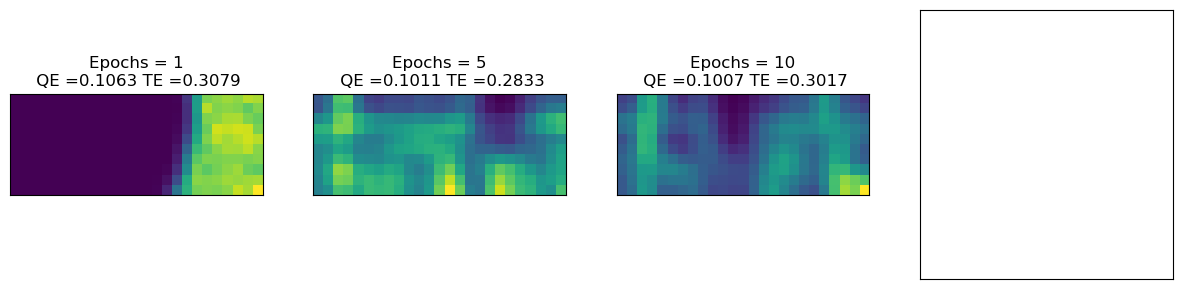

In [16]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5),
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
for epochs, i in zip([1, 4, 5], range(0,3)):
    print(i)
    total_epochs += epochs
    SOM = train_SOM(SOM, n_train_data, learn_rate = .05, radius_sq = 3, epochs = epochs)
    SOMS.append(SOM)
    QE = round(calculateQE(SOM, n_train_data), 4)
    TE = round(calculateTE(SOM, n_train_data), 4)

    ax[i].imshow(u_matrix(SOM))
    ax[i].title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

In [17]:
SOM = SOMS[-1]
bmu_index = find_BMU(SOM, normalise(train_data, featureTextPairs[1280]['feature']))

best_match_contents = []

if isinstance(featureTextPairs[bmu_index[0] * SOM.shape[1] + bmu_index[1]], list):
    for content in featureTextPairs[bmu_index[0] * SOM.shape[1] + bmu_index[1]]:
        best_match_contents.append(content['sentence'])
else:
    best_match_contents.append(featureTextPairs[bmu_index[0] * SOM.shape[1] + bmu_index[1]]['sentence'])

print("index content:", featureTextPairs[1280]['sentence'])
print("best matches:", best_match_contents)

index content: page need employment to prevent them from idle and wanton so formed from that lot of disorderly a troop of well helpful boy with a purpose in life and a good deed to do trio and even a tattoo so for old let us give three company for a jolly good fellow thank you my the rum tum tugger company the rum tum tugger is a curious cat tugger if you offer me id rather have grouse if you put me in a i would much prefer a flat if you put me in a i would rather have a house if you set me on a then i only want a rat if you set me on a then id rather chase a mouse company the rum tum tugger is a curious cat tugger and there any need for me to shout it company for he will do as he do do tugger and theres nothing doing about it the rum tum tugger is a terrible bore tugger when you let me then i want to go out always on the wrong side of every door and as soon as at then id like to get about i like to lie in the bureau drawer but i make such a fuss if i cant get out company the rum tum t

In [19]:
SOMimages = []
for i in range(len(SOM)):
    row = []
    for j in range(len(SOM[0])):
        row.append([])
    SOMimages.append(row)
for f, fi in zip(n_train_data, featureTextPairs):
    g,h = find_BMU(SOM, f)
    SOMimages[g][h].append(fi)
from scipy import spatial

imageGrid = []
for g in range(len(SOMimages)):
    row = SOMimages[g]
    for h in range(len(row)):
        cell = row[h]
        if len(cell) > 0:
            imageGrid.append(cell[0]['sentence'])
        else:
            imageGrid.append('white.png')

print(len(SOMimages))
print(len(SOMimages[0]))

10
25


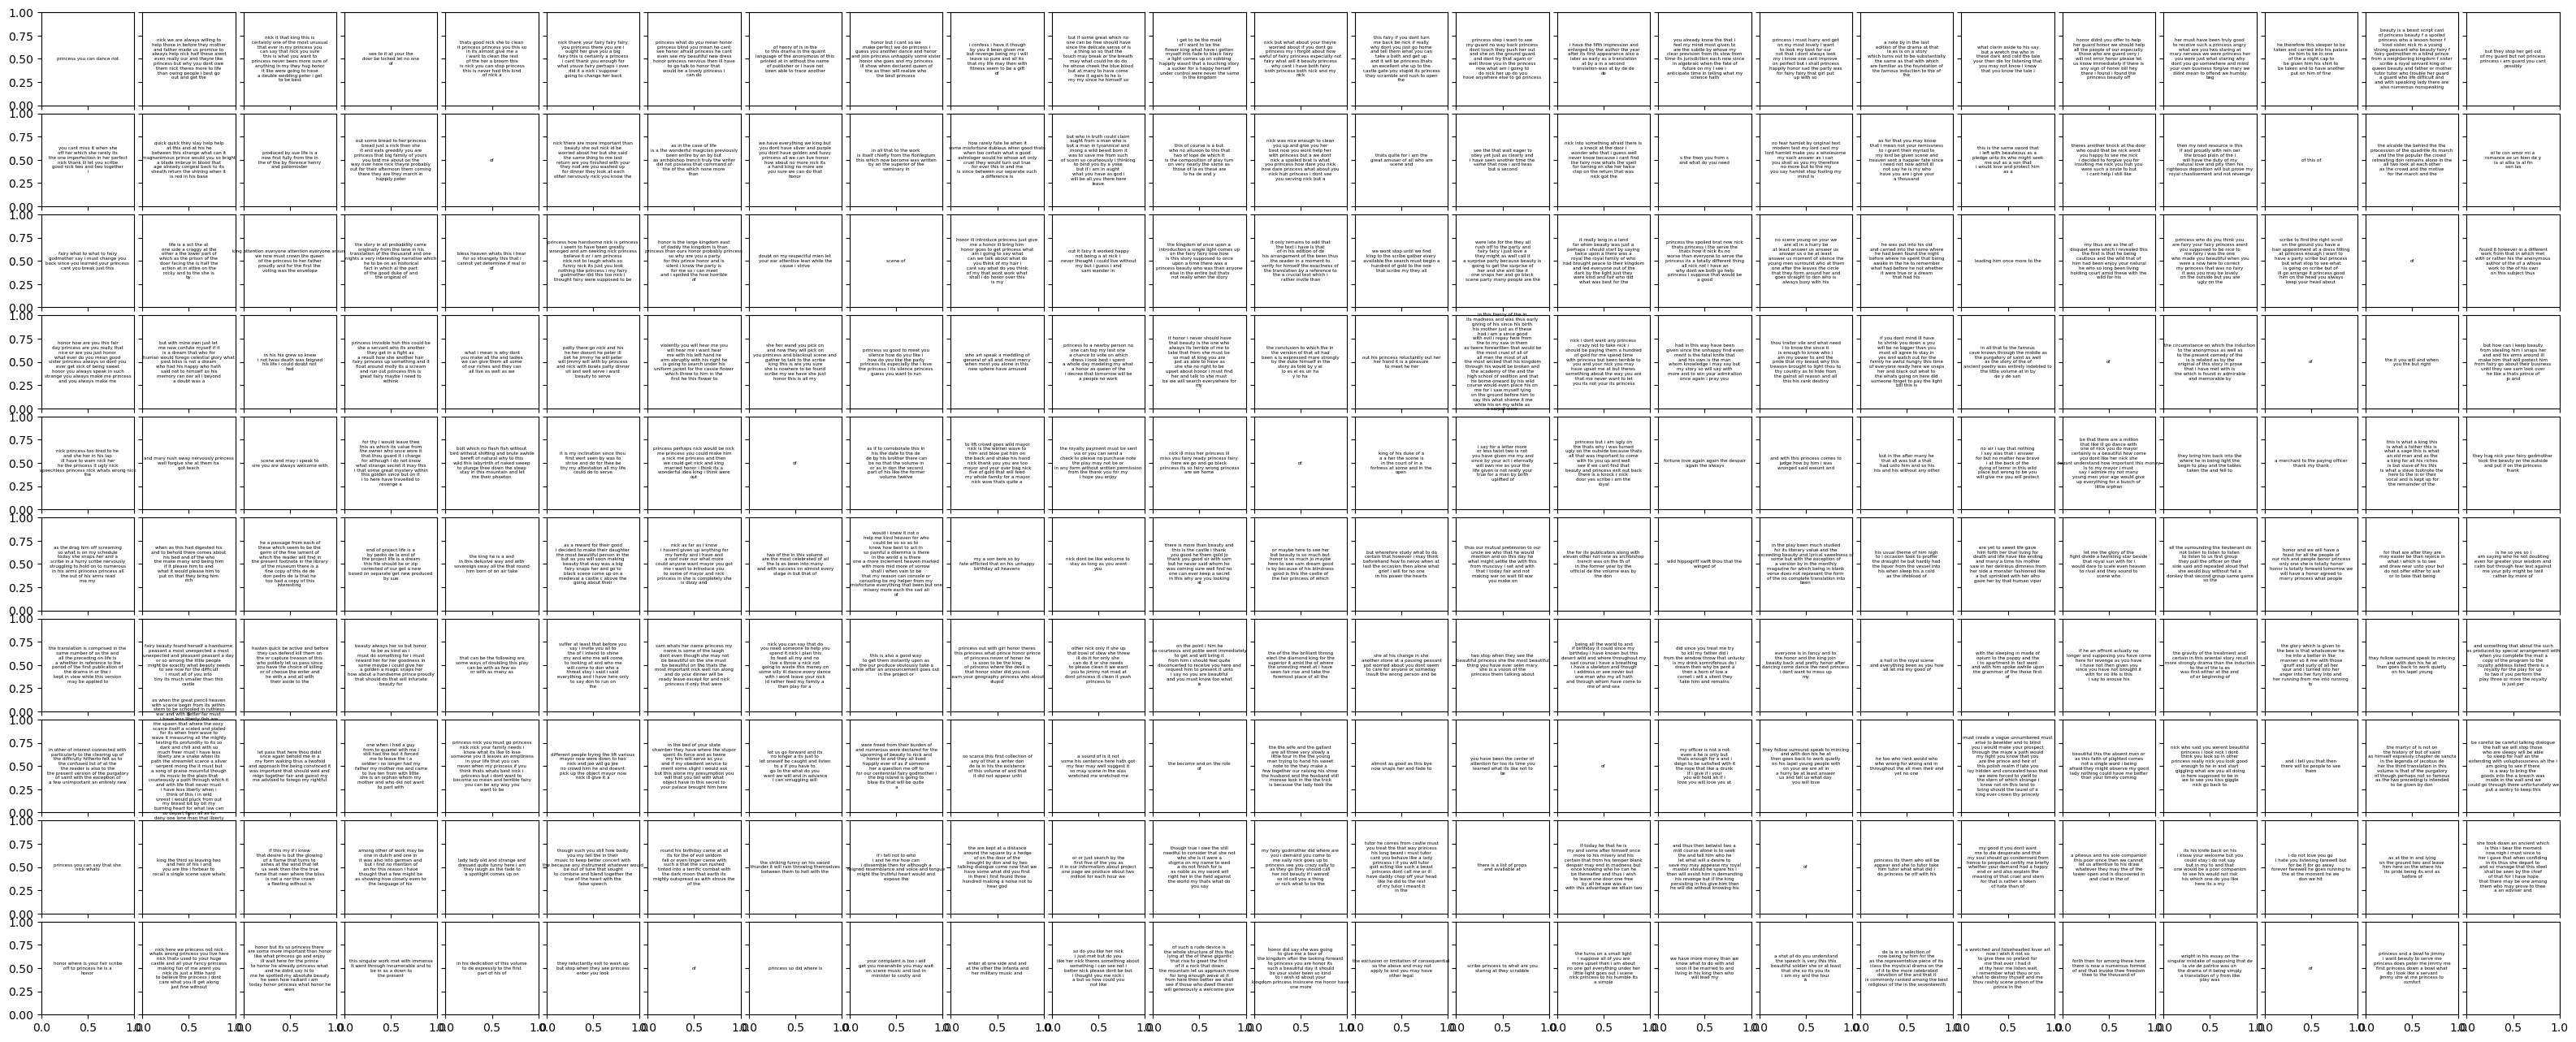

In [22]:

words_per_line = 6

fig = plt.figure(figsize=(40, 20))  

grid = ImageGrid(fig, 111,
                 nrows_ncols=(m, n),  
                 axes_pad=0.1,          
                 )

for i in range(m):
    for j in range(n):
        cell = SOMimages[i][j]
        if cell:
            sentence = cell[0]['sentence']
            words = sentence.split()
            lines = [' '.join(words[k:k+words_per_line]) for k in range(0, len(words), words_per_line)]
            formatted_sentence = '\n'.join(lines)
            grid[i * n + j].set_xlim(0, 1)
            grid[i * n + j].set_ylim(0, 1)
            grid[i * n + j].text(0.5, 0.5, formatted_sentence, va='center', ha='center', fontsize=4)  
        else:
            grid[i * n + j].text(0.5, 0.5, "", va='center', ha='center', fontsize=6)  

plt.show()

In [24]:
input_sentence = "Of course, #Brexit could mean carrying on paying the #EU for free trade, unrestricted free movement & cloning EU law. #NoDebate? #BBCQT"


input_vector = doc2vec_model.infer_vector(input_sentence.split())

normalised_input_vector = normalise(train_data, input_vector)
bmu_index = find_BMU(SOM, normalised_input_vector)
print(bmu_index)

matched_sentences = []
for cell in SOMimages[bmu_index[0]][bmu_index[1]]:
    matched_sentences.append(cell['sentence'])

print("Your input sentence:", input_sentence)
print("Matched sentences from the BMU cell:")
for sentence in matched_sentences:
    print("-", sentence)

(1, 12)
Your input sentence: Of course, #Brexit could mean carrying on paying the #EU for free trade, unrestricted free movement & cloning EU law. #NoDebate? #BBCQT
Matched sentences from the BMU cell:
- nick was nice enough to clean you up and give you her best now you wont help her with princess but a we dont nick a spoiled brat is what you princess how dare you nick how dare princess what about you nick huh princess i dont see you serving nick but a
- honor so glad your princess i dont know what would have to me if it been for king nick nick on his your king please the all start to gather are you really the king king really the
- the preoccupation of a subject by a great master immense in the way of any one who to follow in the same path but as himself great in his and either from carelessness or an imperfect knowledge of is occasionally unfaithful to the meaning of his it may be hoped in my own version that strict fidelity both as to the form as well as substance of the original ma

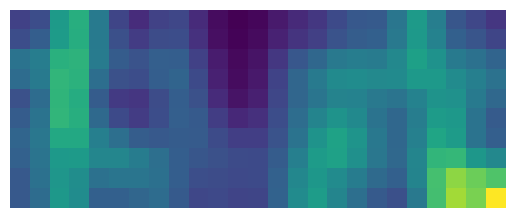

In [25]:
fig = plt.figure()
plt.imshow(u_matrix(SOM))
plt.axis('off')
plt.show()

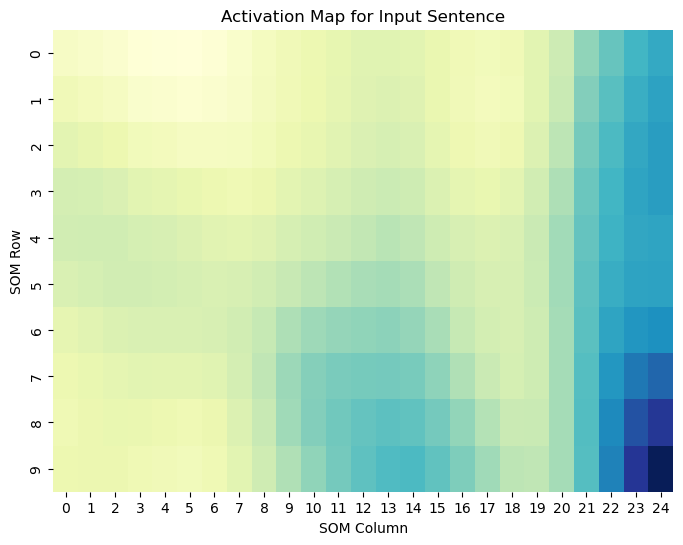

In [26]:
def plot_activation_map(activation_map, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(activation_map, cmap="YlGnBu", annot=False, cbar=False)
    plt.title(title)
    plt.xlabel("SOM Column")
    plt.ylabel("SOM Row")
    plt.show()

activation_map = activate(train_data, SOM, train_data[1280])
plot_activation_map(activation_map, "Activation Map for Input Sentence")